# Optimization

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import lstsq, multi_dot
from numpy.polynomial.polynomial import Polynomial as Poly
from scipy import linalg, optimize

## Introduction

Optimization problems arise in all areas of science (and are perhaps even more common in engineering, business and industry). Any design does not only have a requirement that it works, but also involves the optimization of some figure of merit, like cost or efficiency. 
Out of all possible designs, we want the one that optimizes some objective.

Of course, the result will depend on the objective: an engine optimized to deliver maximum power will be very different from one optimized for fuel efficiency.

Next to the objective function, typically there are also some **constraints** that need to be fulfilled. For instance, when designing a bridge, we can optimize for weight or cost, but we still need to make sure it has a certain minimum strength. 
Among all feasible choices, however, we want to find the one that optimizes the cost/weight.

There is also a certain duality that constraints can become objectives and vice versa. 
There is an intimate relationship between such dual problems, whose solutions are often identical. 
For example, the lightest bridge that can support a certain load, typically is the strongest bridge given its weight.

From the previous description, it seems that optimization problems are mainly the concern of people who design certain objects like bridges, engines,...
However, also physical systems evolve towards a configuration of minimum energy, which we can study using the optimization techniques found in this notebook. 

### Concepts and notation

An optimization problem can be expressed mathematically as the problem of determining an argument for which a given function has an extreme value (minimum or maximum) on a given domain.

Formally, given a function $f:\mathbb{R}^n \rightarrow \mathbb{R}$, and a set $S\subseteq\mathbb{R}^n$, we seek $\mathbf{x}^*\in S$ such that $f$ attains a minimum on $S$ at $\mathbf{x}^*$, i.e. $f(\mathbf{x}^*)\leq f(\mathbf{x})$ for all $\mathbf{x}\in S$.

Such a point $\mathbf{x^*}$ is called a **minimizer**, or simply a **minimum** of $f$. A maximum of $f$ is a minimum of $-f$, so it suffices to consider minimization.

The **objective function** $f$ may be linear or nonlinear, and it is usually assumed to be differentiable. 
The set $S$ is usually defined by a set of equations and inequalities, called **constraints**, which may be linear of nonlinear. 
Any vector $\mathbf{x} \in S$, i.e. that satisfies the constraints, is called a **feasible point**, and $S$ is called the **feasible set**. 
If $S=\mathbb{R}^n$, the problem is **unconstrained**

A general **continuous** optimization problem (note that we will not address **discrete** optimization problems) has the form

$$
\min_{\mathbf{x}} f(\mathbf{x})\quad \text{subject to}\quad\mathbf{g(x)=0}\quad \mathrm{and}\quad\mathbf{h(x)\leq0}
$$

where $f:\mathbb{R}^n\rightarrow\mathbb{R}$, $\mathbf{g}:\mathbb{R}^n\rightarrow\mathbb{R}^m$ and $\mathbf{h}:\mathbb{R}^n\rightarrow\mathbb{R}^p$.

Optimization problems are classified by the properties of the functions involved. 
For example if $f$, $\mathbf{g}$ and $\mathbf{h}$ are all linear, then we have a **linear programming** problem. 
If any of them are nonlinear, we have a **nonlinear programming** problem. 
Note that the term programming in optimization has nothing to do with computer programming, but instead refers to planning activities in the sense of management.

What constitutes a solution to an optimization problem?
A **global minimum** satisfies $f(\mathbf{x}^*)\leq f(\mathbf{x})$ for *any* feasible point $\mathbf{x}$. 
Finding such a global minimum, or even verifying that a point is a global minimum is difficult unless the problem has special properties.

Most optimization methods use local information, such as derivatives, and consequently are designed to find a **local minimum**. 
Often the best one can do to find a global minimum is use a very large set of starting points, widely scattered throughout the feasible set. 
The lowest minimum found this way has a good (but not perfect) chance of being the global minimum.

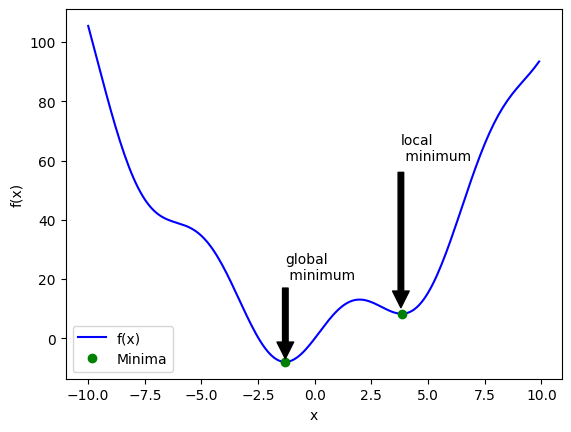

In [3]:
def plot_concept():
    def f(x):
        return x**2 + 10 * np.sin(x)

    x = np.arange(-10, 10, 0.1)
    plt.close("concept")
    fig, ax = plt.subplots(num="concept")

    # Plot the function
    ax.plot(x, f(x), "b-", label="f(x)")

    # Plot the minima
    xmins = np.array([-1.30641113, 3.8374671194983834])
    ax.plot(xmins, f(xmins), "go", label="Minima")

    # Decorate the figure
    ax.annotate(
        "global\n minimum",
        xy=(-1.3, f(-1.3)),
        xytext=(-1.3, 20),
        arrowprops=dict(facecolor="black", shrink=0.04),
    )
    ax.annotate(
        "local\n minimum",
        xy=(3.8, f(3.8)),
        xytext=(3.8, 60),
        arrowprops=dict(facecolor="black", shrink=0.04),
    )
    ax.legend(loc="best")
    ax.set_xlabel("x")
    ax.set_ylabel("f(x)")


plot_concept()

## Optimality conditions

### Unconstrained optimality conditions

The **first-order necessary condition** for a minimum is that the **gradient** of the objective function $f$ is zero.

$$
\nabla{f}(\mathbf{x^*})=0
$$

Such an $\mathbf{x^*}$ is called a **critical point** and the gradient is defined by 

$$
\nabla f(\mathbf{x})=\begin{bmatrix}\frac{\partial f(\mathbf{x})}{\partial x_1}\\
\frac{\partial f(\mathbf{x})}{\partial x_2}\\
\vdots\\
\frac{\partial f(\mathbf{x})}{\partial x_n}
\end{bmatrix}
$$

To understand the first-order necessary condition one should remember that the gradient always points *uphill* from $f(\mathbf{x})$. 
Similarly, the negative gradient, $-\nabla{f}(\mathbf{x^*})$ always points *downhill* from $f(\mathbf{x})$.
Since there is no *downhill* direction at a minimum, the gradient must be zero. 
An analogous reasoning applies for a maximum. 

> **Equilibrium**
>
> Physically, the same condition corresponds to an equilibrium: a minimum of the potential energy must occur at a critical point of $V$, i.e. when $\nabla V=0$. We recall that force is defined by the negative gradient of the potential energy:
>
> $$
\mathbf{F}(x)=-\nabla V(x)
$$
>
> Thus the negative gradient of the potential energy is zero and the system is in equilibrium when there are no net forces.


In general, it is necessary but not sufficient that $\mathbf{x}$ is a critical point of $f$ for it to be a **minimum** of $f$. 
A critical point can either be a minimum, a maximum or a saddle point. 
To classify the critical points, we need another criterion.

Consider the **Hessian matrix** of $f$. 
This is a matrix-valued function $\mathbf{H}_f$ (only defined if $f$ is twice differentiable).

$$
\mathbf{H}_f(\mathbf{x})=\begin{bmatrix}
\frac{\partial^2 f(\mathbf{x})}{\partial x_1^2}  & \frac{\partial^2 f(\mathbf{x})}{\partial x_1\partial  x_2}  & \cdots & \frac{\partial^2 f(\mathbf{x})}{\partial x_1\partial x_n}  \\
\frac{\partial^2 f(\mathbf{x})}{\partial x_1\partial x_2}  & \frac{\partial^2 f(\mathbf{x})}{\partial x_2^2}  & \cdots & \frac{\partial^2 f(\mathbf{x})}{\partial x_2\partial x_n}  \\
\vdots&\vdots& \ddots&\vdots\\
\frac{\partial^2 f(\mathbf{x})}{\partial x_n\partial x_1}  & \frac{\partial^2 f(\mathbf{x})}{\partial x_n\partial x_2}  & \cdots &\frac{\partial^2 f(\mathbf{x})}{\partial x_n^2}  \\
\end{bmatrix}
$$

We can then classify critical points as follows:

At a critical point $\mathbf{x}^*$, where $\nabla f(\mathbf{x})=\mathbf{0}$, if $\mathbf{H}_f(\mathbf{x}^*)$ is...
- Positive definite, then $\mathbf{x}^*$ is a minimum of $f$
- Negative definite, then $\mathbf{x}^*$ is a maximum of $f$
- Indefinite, then $\mathbf{x}^*$ is a saddle point of $f$
- Singular, then various pathological situations can occur

This is called the **second-order sufficient condition**. 

> **Example**
>
> Consider the function
> 
> $$
f(\mathbf{x})=2x^3_1+3x_1^2+12x_1x_2+3x^2_2-6x_2+6
$$
>
> It's gradient is given by 
>
> $$
\nabla f(\mathbf{x})=\begin{bmatrix}
6x_1^2+6x_1+12x_2\\
12x_1+6x_2-6\end{bmatrix}
$$
>
> Solving the nonlinear system $\nabla f(\mathbf{x})=0$ yields two critical points, $[1\quad -1]^\intercal$ and $[2\quad -3]^\intercal$.
>
> The Hessian matrix is given by
>
> $$
\mathbf{H}_f(\mathbf{x})=\begin{bmatrix}
12x_1+6&12\\
12&6
\end{bmatrix}
$$
>
> Evaluating $\mathbf{H}_f(\mathbf{x})$ at each of the critical points gives
> 
> $$
\mathbf{H}_f(1,-1)=\begin{bmatrix}18&12\\12 & 6\end{bmatrix}
$$
>
> and
>
> $$
\mathbf{H}_f(2,-3)=\begin{bmatrix}30&12\\12 & 6\end{bmatrix}
$$
>
> The Hessian at the first point is not positive definite (its eigenvalues are approximately 25.4 and -1.4), whereas it is positive definite at the second point (with eigenvalues of approximately 35 and 1).
>
> We can therefore conclude that $[1\quad -1]^\intercal$ is a saddle point and $[2\quad -3]^\intercal$ is a local minimum of $f$.

> The following cells give a visual representation of the example above.
> First the function is defined, followed by two cell for the plots.
> The plots show respectively a 3D and 2D graph of the function $f(\mathbf{x})$.
> The two critical points are explicitly marked in both graphs.

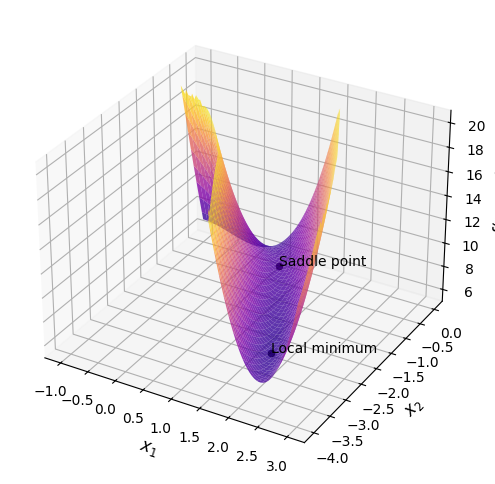

In [4]:
def func_surface(x1, x2):
    """Function from the example above."""
    return 2 * x1**3 + 3 * x1**2 + 12 * x1 * x2 + 3 * x2**2 - 6 * x2 + 6


def plot_example_3d():
    # Create a meshgrid for 3D plot
    x1 = np.linspace(-1, 3, 100)
    x2 = np.linspace(-4, 0, 100)
    x1, x2 = np.meshgrid(x1, x2)
    # Compute the function and truncate high values with nan
    # to show only the surface near the stationary points.
    z = func_surface(x1, x2)
    z[z > 20] = np.nan

    # Create 3D plot
    plt.close("example3d")
    fig = plt.figure(figsize=(6, 6), num="example3d")
    ax = fig.add_subplot(projection="3d")
    ax.plot_surface(x1, x2, z, cmap="plasma", alpha=0.8)

    # Critical points with text
    critical_points = {"Saddle point": [1, -1], "Local minimum": [2, -3]}
    for label, point in critical_points.items():
        ax.scatter(*point, func_surface(*point), c="k")
        ax.text(*point, func_surface(*point), label, color="black", zorder=10)

    # Add labels, legend and title
    ax.set_xlabel("$x_1$", fontsize=12)
    ax.set_ylabel("$x_2$", fontsize=12)
    ax.set_zlabel("f($x_1$, $x_2$)", fontsize=12)


plot_example_3d()

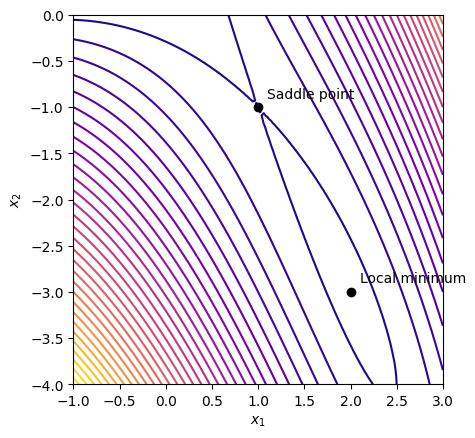

In [5]:
def plot_example_2d():
    # Create a meshgrid for 2D plot
    x1 = np.linspace(-1, 3, 100)
    x2 = np.linspace(-4, 0, 100)
    x1, x2 = np.meshgrid(x1, x2)

    plt.close("example2d")
    fig, ax = plt.subplots(num="example2d")
    ax.contour(x1, x2, func_surface(x1, x2), levels=30, cmap="plasma")
    ax.set_aspect("equal")

    # Critical points with text
    critical_points = {"Saddle point": [1, -1], "Local minimum": [2, -3]}
    for label, point in critical_points.items():
        plt.plot(point[0], point[1], "ko")
        plt.text(point[0] + 0.1, point[1] + 0.1, label, color="black", zorder=10)

    # Add labels, legend and title
    ax.set_xlabel("$x_1$")
    ax.set_ylabel("$x_2$")


plot_example_2d()

## Optimization in one dimension

The techniques used here are similar to the ones used to find the solution to one-dimensional nonlinear equations, where we used a sign change to bracket the solution.

A function $f:\mathbb{R}\rightarrow \mathbb{R}$ is **unimodal** on an interval $[a,b]$ if there is a unique $x^*\in [a,b]$ such that $f(x^*)$ is the minimum value of $f$ on $[a,b]$, and for any $x_1, x_2\in [a,b]$ with $x_1<x_2$, 

$x_2<x^*$ implies $f(x_1)>f(x_2)$ and $x_1>x^*$ implies $f(x_1)<f(x_2)$.

Thus, $f(x)$ is strictly decreasing for $x\leq x^*$ and strictly increasing for $x\geq x^*$. 
This property will allow us to refine an interval containing a solution by computing sample values of the function within the interval and discarding portions of the interval according to the function values obtained, analogous to bisection for solving nonlinear equations.

### Demo function

The same univariate function is used to demonstrate all the implementations below.
You can change the definition here and rerun the examples to test the algorithms for a different case.

In [6]:
def func_single(x):
    """The demo function."""
    return 0.5 - x * np.exp(-x * x)


def func_single_p(x):
    """First derivative of the demo function."""
    return (2 * x**2 - 1) * np.exp(-x * x)


def func_single_pp(x):
    """Second derivative of the demo function."""
    return 2 * x * (3 - 2 * x**2) * np.exp(-x * x)

### Golden section search

Suppose $f$ is unimodal on $[a,b]$, and let $x_1,x_2\in[a,b]$ with $x_1<x_2$. 
By comparing the function values $f(x_1)$ and $f(x_2)$ we can exclude a subinterval, either $(x_2,b]$ or $[a, x_1)$ because we know that the minimum lies within the remaining subinterval.

In particular, if $f(x_1)<f(x_2)$, than the minimum cannot lie in the interval $(x2,b]$ and if on the other hand $f(x_1)>f(x_2)$ than the minimum cannot lie in the interval $[a,x_1)$.

This means that we are left with a shorter interval of which we already know one function value. 
Hence, we only need to calculate one more to repeat this process until our bracket reaches a certain tolerance.

To make consistent progress in reducing the length of the interval containing the minimum, each pair of points in the new interval should have the same relative position as the old pair in the old interval.

To accomplish this objective, we choose the relative positions of the two points to be $\tau$ and $1-\tau$ , where $\frac{\tau}{1}=\frac{1-\tau}{\tau}\rightarrow\tau^2=1-\tau$, so that $\tau=(\sqrt(5)-1)/2\approx0.618$ (the "golden ratio") and $1-\tau\approx 0.382$. The complete procedure converges linearly to a local minimum *if* the function is unimodal within the initial bracket.

In the following cells, an algorithm for golden section search is shown, together with an example and the corresponding `scipy` command to solve the same example problem.

  i           x1           x2        x2-x1
---  -----------  -----------  -----------
  0  0.000000000  2.000000000  2.000000000
  1  0.000000000  1.236067977  1.236067977
  2  0.472135955  1.236067977  0.763932023
  3  0.472135955  0.944271910  0.472135955
  4  0.472135955  0.763932023  0.291796068
  5  0.583592135  0.763932023  0.180339887
  6  0.652475842  0.763932023  0.111456180
  7  0.652475842  0.721359550  0.068883707
  8  0.678787077  0.721359550  0.042572473
  9  0.695048315  0.721359550  0.026311235
 10  0.695048315  0.711309553  0.016261238
 11  0.701259555  0.711309553  0.010049997
 12  0.705098312  0.711309553  0.006211240
 13  0.705098312  0.708937070  0.003838757
 14  0.706564587  0.708937070  0.002372483
 15  0.706564587  0.708030862  0.001466275
 16  0.706564587  0.707470795  0.000906208
 17  0.706910728  0.707470795  0.000560067
 18  0.706910728  0.707256868  0.000346141
 19  0.707042942  0.707256868  0.000213927
 20  0.707042942  0.707175156  0.000132214
 21  0.7070

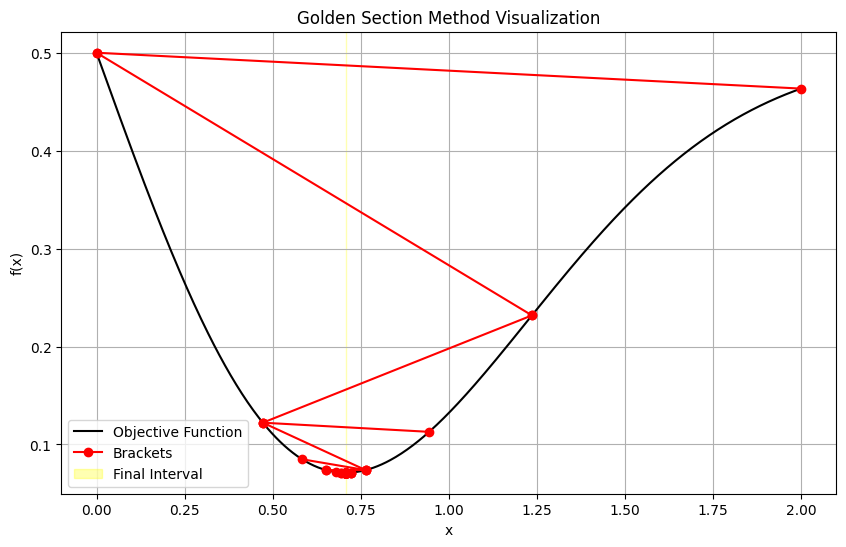

In [7]:
def my_golden(f, a, b, tol):
    """Illustrative implementation of the Golden Section
    method with visualization."""
    brackets = [[a, b]]
    i = 0
    print("  i           x1           x2        x2-x1")
    print("---  -----------  -----------  -----------")
    print(f"{0:3d}  {a:11.9f}  {b:11.9f}  {b-a:11.9f}")
    t = (np.sqrt(5) - 1) / 2
    x1 = a + (1 - t) * (b - a)
    f1 = f(x1)
    x2 = a + t * (b - a)
    f2 = f(x2)
    points = [[x1, x2]]

    while (b - a) > tol:
        if f1 > f2:
            a = x1
            x1 = x2
            f1 = f2
            x2 = a + t * (b - a)
            f2 = f(x2)
        else:
            b = x2
            x2 = x1
            f2 = f1
            x1 = a + (1 - t) * (b - a)
            f1 = f(x1)
        brackets.append([a, b])
        points.append([x1, x2])
        i = i + 1
        print(f"{i:3d}  {a:11.9f}  {b:11.9f}  {b-a:11.9f}")

    return np.array(brackets), np.array(points)


def plot_golden():
    # Perform the Golden Section method and collect data
    brackets, points = my_golden(func_single, a=0, b=2, tol=1e-6)

    # Generate the static figure
    t = np.linspace(0, 2, 500)
    plt.close("golden")
    fig, ax = plt.subplots(figsize=(10, 6), num="golden")
    ax.plot(t, func_single(t), label="Objective Function", color="black")

    # Plot the brackets and points for each iteration
    for i, (bracket, _point) in enumerate(zip(brackets, points, strict=False)):
        ax.plot(
            bracket,
            [func_single(bracket[0]), func_single(bracket[1])],
            "r-o",
            label="Brackets" if i == 0 else "",
        )

    # Highlight the final region
    ax.axvspan(
        brackets[-1, 0],
        brackets[-1, 1],
        color="yellow",
        alpha=0.3,
        label="Final Interval",
    )

    ax.set_xlabel("x")
    ax.set_ylabel("f(x)")
    ax.set_title("Golden Section Method Visualization")
    ax.legend()
    ax.grid(True)


plot_golden()

### Successive parabolic interpolation

The golden section search for optimization is analogous to the bisection method to solve a nonlinear equation. Similarly, we do not make use of the function values, other than to compare them. 
We can do better by making better use of the function values.

Fitting a straight line to two points, as in the secant method, is useless as this line does not have any minimum. Instead, we must use a polynomial with degree of at least two.

The simplest such approach is **successive parabolic interpolation**, where the function is evaluated at three points, and a parabola is fitted to the resulting function values. 
The minimum of the parabola is used as a new approximate value of the minimum.

A straightforward implementation in python is shown below, together with an animation of an example problem.

This algorithm is not guaranteed to converge, but if it is started reasonable close to a minimum it converges superlinearly with convergence rate $r\approx1.324$

In [8]:
def my_parabolic_iteration(f, u, v, w, tol):
    """Illustrative implementation of Parabolic Iteration."""
    i = 0
    brackets = []
    brackets.append([v])
    par_points = []
    par_points.append([u, v, w])
    print("  i            v         f(v)")
    print("---  -----------  -----------")
    print(f"{0:3d}  {v:11.9f}  {f(v):11.9f}")
    p = 1.0
    q = 1.0
    while (np.abs(p / q)) >= tol:
        i = i + 1
        p = (v - u) ** 2.0 * (f(v) - f(w)) - (v - w) ** 2.0 * (f(v) - f(u))
        q = 2.0 * ((v - u) * (f(v) - f(w)) - (v - w) * (f(v) - f(u)))
        u = w
        w = v
        v = v - p / q
        print(f"{i:3d}  {v:11.9f}  {f(v):11.9f}")
        brackets.append([v])
        par_points.append([u, w, v])
    return np.array(brackets), np.array(par_points)


# find the zero crossing
pi_results, pi_points = my_parabolic_iteration(
    func_single, u=0.5, v=1.75, w=1.2, tol=1e-8
)

# get coefficients of parabola
pi_coeffs = np.array(
    [Poly.fit(points, func_single(points), 2).convert().coef for points in pi_points]
)

  i            v         f(v)
---  -----------  -----------
  0  1.750000000  0.418151411
  1  0.419584192  0.148147059
  2  0.605337612  0.080378668
  3  0.880216960  0.094392264
  4  0.714539112  0.071165273
  5  0.711575541  0.071135151
  6  0.706466178  0.071118410
  7  0.707100640  0.071118058
  8  0.707107465  0.071118058
  9  0.707106780  0.071118058
 10  0.707106781  0.071118058


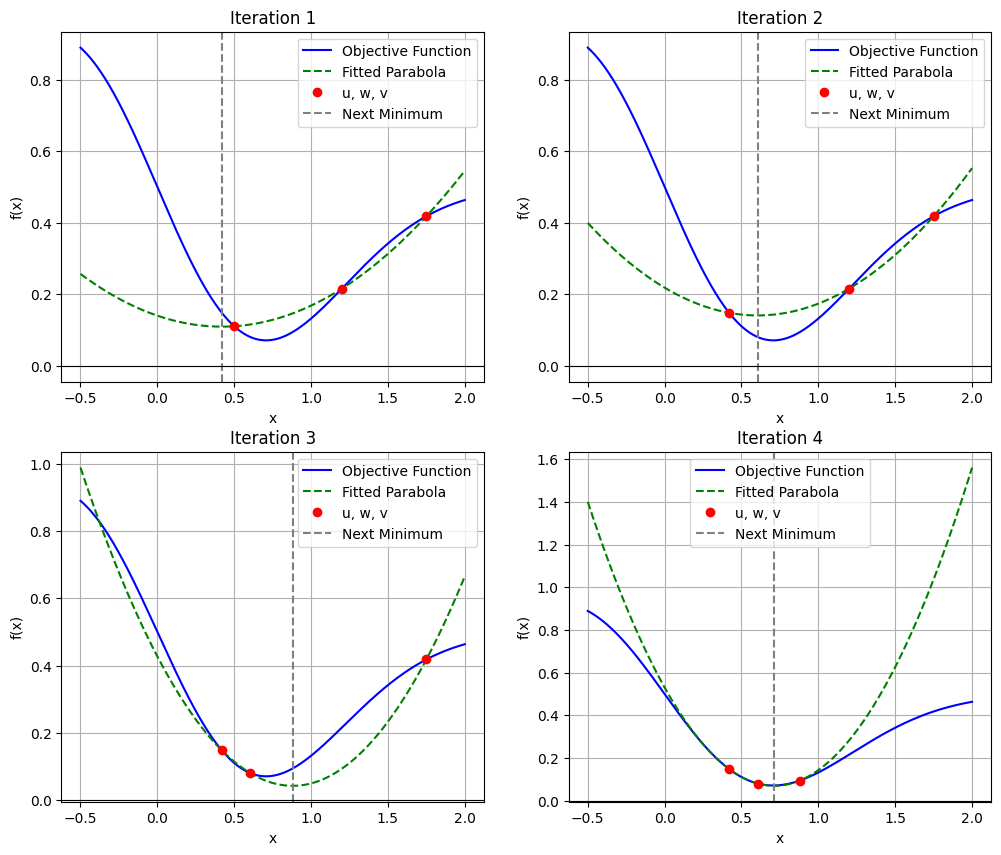

In [9]:
def plot_parabolic_iteration():
    # Generate figure
    x = np.linspace(-0.5, 2, 500)
    plt.close("parabolic")
    fig, axs = plt.subplots(2, 2, figsize=(12, 10), num="parabolic_iteration")
    axs = axs.flatten()

    for i, ax in enumerate(axs[:4]):  # Only plot the first 4 iterations
        if i >= len(pi_points):
            break
        points = pi_points[i]
        coeffs = pi_coeffs[i]
        parabola = coeffs[2] * x**2 + coeffs[1] * x + coeffs[0]

        # Plot the function and the fitted parabola
        ax.plot(x, func_single(x), label="Objective Function", color="blue")
        ax.plot(x, parabola, "--", label="Fitted Parabola", color="green")

        # Highlight the points u, w, and v
        ax.plot(points, func_single(points), "ro", label="u, w, v")
        ax.axvline(
            pi_results[i + 1][0], color="grey", linestyle="--", label="Next Minimum"
        )

        # Labels and titles
        ax.set_title(f"Iteration {i + 1}")
        ax.set_xlabel("x")
        ax.set_ylabel("f(x)")
        ax.axhline(0, color="black", linewidth=0.8)
        ax.legend()
        ax.grid()


plot_parabolic_iteration()

### Newton's method

As we saw in the previous method, a quadratic approximation to the objective function is useful because its minimum is easy to compute. 
Instead of fitting this function, we can also obtain a local quadratic approximation based on a truncated Taylor expansion.

$$
f(x+h)\approx f(x)+f'(x)h+\frac{1}{2}f''(x)h^2
$$

The minimum of this function is given by $-f'(x)/f''(x)$, which we can use to find the minimum of the objective function in an iterative way.

This method is equivalent to Newton's method for solving nonlinear equations, and also has a quadratic convergence rate. 
However, unless it is started sufficiently close to the desired minimum it might not converge at all, or converge to a maximum or inflection point instead.

A straightforward implementation in python is shown below, together with an animation of an example problem.

In [10]:
def my_newton_method(f, fp, fpp, x, tol):
    """Illustrative implementation of the 1D Newton method."""
    i = 0
    brackets = []
    brackets.append([x])
    print("  i            x         f(x)")
    print("---  -----------  -----------")
    print(f"{0:3d}  {x:11.9f}  {f(x):11.9f}")
    diff = 1.0
    while (np.abs(diff)) >= tol:
        i = i + 1
        diff = fp(x) / fpp(x)
        x = x - diff
        print(f"{i:3d}  {x:11.9f}  {f(x):11.9f}")
        brackets.append([x])
    return np.array(brackets)


results = my_newton_method(
    func_single, func_single_p, func_single_pp, x=1.0, tol=1e-8
)

  i            x         f(x)
---  -----------  -----------
  0  1.000000000  0.132120559
  1  0.500000000  0.110599608
  2  0.700000000  0.071161524
  3  0.707072136  0.071118059
  4  0.707106780  0.071118058
  5  0.707106781  0.071118058


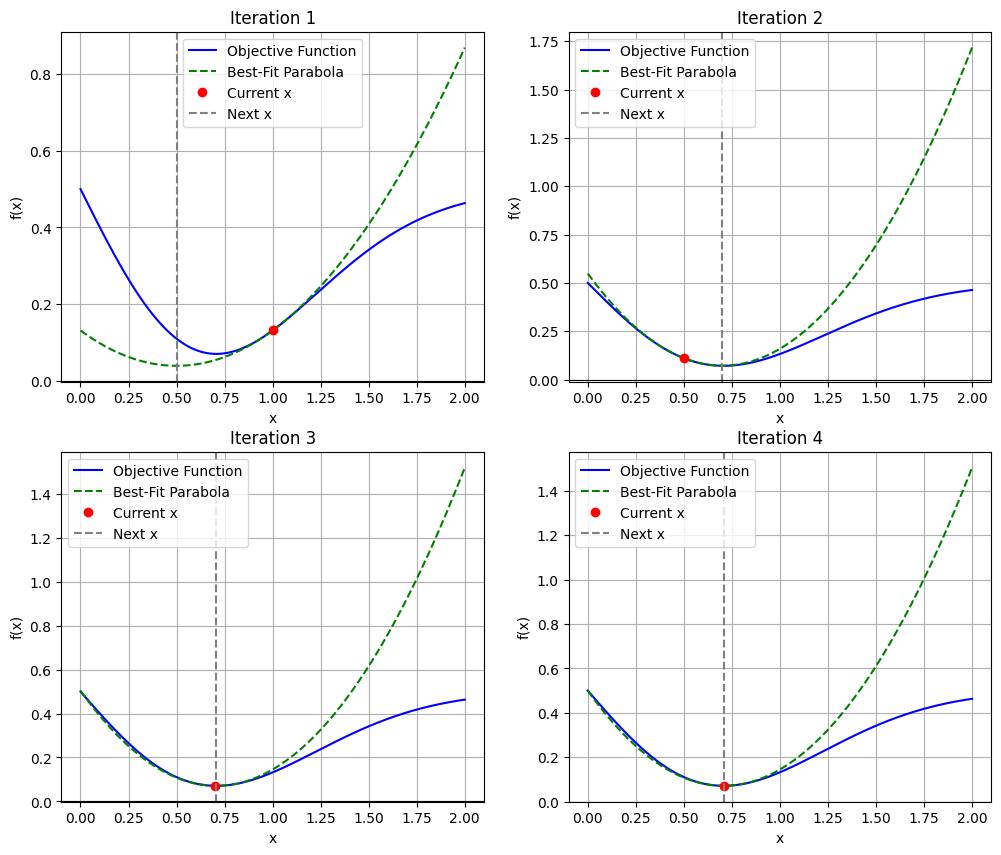

In [11]:
def plot_newton_method():
    x_range = np.linspace(0, 2.0, 500)
    plt.close("newton_method")
    fig, axs = plt.subplots(2, 2, figsize=(12, 10), num="newton_method")
    axs = axs.flatten()

    # Only plot the first 4 iterations
    for i, ax in enumerate(axs[:4]):
        if i >= len(results) - 1:
            break

        x_current = results[i][0]
        x_next = results[i + 1][0] if i + 1 < len(results) else x_current

        # Plot the function
        ax.plot(
            x_range, func_single(x_range), label="Objective Function", color="blue"
        )

        # Plot the best-fit parabola
        f_val = func_single(x_current)
        f_prime = func_single_p(x_current)
        f_double_prime = func_single_pp(x_current)
        parabola = (
            f_val
            + f_prime * (x_range - x_current)
            + 0.5 * f_double_prime * (x_range - x_current) ** 2
        )
        ax.plot(x_range, parabola, "--", label="Best-Fit Parabola", color="green")

        # Highlight the current point
        ax.plot(x_current, func_single(x_current), "ro", label="Current x")
        ax.axvline(x_next, color="grey", linestyle="--", label="Next x")

        # Labels and titles
        ax.set_title(f"Iteration {i + 1}")
        ax.set_xlabel("x")
        ax.set_ylabel("f(x)")
        ax.axhline(0, color="black", linewidth=0.8)
        ax.legend()
        ax.grid()


plot_newton_method()

## Multidimensional unconstrained optimization

We next consider multidimensional unconstrained optimization, which has a number of features in common with both one-dimensional optimization and with solving of linear equations in *n* dimensions. 

> Below, several optimization methods are discussed and as a two-dimensional example, the function
>
> $$
f(\mathbf{x}) = 0.5x_1^2 + x_1 + 2.5x_2^2 + 1
$$
>
> will be optimized using each method. To illustrate the effectiveness of these methods, they will be compared to each other at the end of this section.
>
> You easily replace this test function by the more challenging Himmelblau function in the following cell.

In [7]:
def get_demo_func_quadratic():
    def func(x):
        """Example function to be minimized."""
        return 0.5 * x[0] ** 2 + x[0] + 2.5 * x[1] ** 2 + 1

    def func_p(x):
        """Gradient of the example function."""
        g0 = x[0] + 1
        g1 = 5 * x[1]
        return np.array([g0, g1])

    def func_pp(x):
        """The Hessian of the example function."""
        # Easy: just a constant matrix
        return np.array([[1, 0], [0, 5]])

    return func, func_p, func_pp


def get_demo_func_himmelblau():
    def func(x):
        """Himmelblau function."""
        return (x[0] ** 2 + x[1] - 11) ** 2 + (x[0] + x[1] ** 2 - 7) ** 2

    def func_p(x):
        """Gradient of the Himmelblau function."""
        g0 = 4 * x[0] * (x[0] ** 2 + x[1] - 11) + 2 * (x[0] + x[1] ** 2 - 7)
        g1 = 2 * (x[0] ** 2 + x[1] - 11) + 4 * x[1] * (x[0] + x[1] ** 2 - 7)
        return np.array([g0, g1])

    def func_pp(x):
        """Hessian matrix of the Himmelblau function."""
        h00 = 12 * x[0] ** 2 + 4 * x[1] - 42
        h01 = 4 * x[0] + 4 * x[1]
        h11 = 12 * x[1] ** 2 + 4 * x[0] - 26
        return np.array([[h00, h01], [h01, h11]])

    return func, func_p, func_pp


func_multi, func_multi_p, func_multi_pp = get_demo_func_quadratic()
# func_multi, func_multi_p, func_multi_pp = get_demo_func_himmelblau()

To illustrate the result of a single case, the following `plot_opt_traj` function is used.

In [8]:
def plot_opt_trajectory(results, num):
    """Plot the optimization trajectory."""
    plt.close(num)
    fig, ax = plt.subplots(figsize=(8, 4), num=num)
    x = np.linspace(-8, 8, 100)
    y = np.linspace(-4.3, 4.3, 100)

    xx, yy = np.meshgrid(x, y, sparse=False)
    zz = func_multi(np.array([xx, yy]))
    clevels = np.array([func_multi(results_sd[i, 0]) for i in range(10)])

    ax.contour(x, y, zz, np.flip(clevels))
    ax.plot(
        results[:, 0, 0],
        results[:, 0, 1],
        "-o",
        markersize=7,
        color="r",
        alpha=0.5,
    )
    ax.set_xlim(-8, 8)
    ax.set_ylim(-4.3, 4.3)

### Direct Search

Analogous to the golden section search for one-dimensional optimization, in direct search methods for multidimensional optimization the objective function values are only *compared* to each other. 
However, in contrast to the golden section search, they do not retain the convergence guarantee. 

Perhaps the best known direct search method is the one of **Nelder and Mead**. 
To seek the minimum of a function $f:\mathbb{R}^n\rightarrow \mathbb{R}$, the function is first evaluated at $n+1$ starting points. 
These $n+1$ starting points form a *simplex* meaning that no three points are colinear (e.g. a simplex in two dimensions, has three points which form a triangle). 
A new point is generated along the straight line connecting the point with the highest function value (the *worst* point) and the centroid of the remaining $n$ points. 
This new point then replaces the worst point and the process is repeated until convergence. 

Direct search methods are especially useful for nonsmooth objective functions, for which few other methods are applicable, and they can be effective when $n$ is small, but they tend to be quite expensive when $n$ is larger than two or three. 
One advantage of direct search methods is that they can easily be parallelized. 

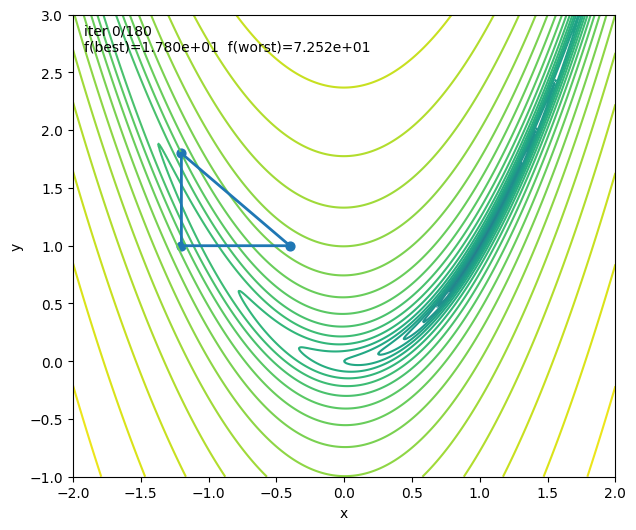

In [26]:
if __name__ == "__main__":
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.animation import FuncAnimation

    # ----------------------------
    # Kies een objective f(x,y)
    # ----------------------------
    def rosenbrock(p, a=1.0, b=100.0):
        x, y = p
        return (a - x)**2 + b*(y - x**2)**2

    def himmelblau(p):
        x, y = p
        return (x**2 + y - 11)**2 + (x + y**2 - 7)**2


    # ----------------------------
    # Nelder–Mead (2D) + history
    # ----------------------------
    def nelder_mead_2d(f, x0, step=1.0, max_iter=200,
                    alpha=1.0, gamma=2.0, rho=0.5, sigma=0.5):
        """
        Nelder–Mead simplex in 2D.
        Return: history = lijst van simplex (3x2 arrays) per iteratie.
        """
        x0 = np.asarray(x0, dtype=float)

        # Initial simplex: x0, x0 + step*e1, x0 + step*e2
        simplex = np.array([
            x0,
            x0 + np.array([step, 0.0]),
            x0 + np.array([0.0, step])
        ], dtype=float)

        history = [simplex.copy()]

        for _ in range(max_iter):
            # Sorteer op f: best (0), middle (1), worst (2)
            vals = np.array([f(p) for p in simplex])
            order = np.argsort(vals)
            simplex = simplex[order]
            vals = vals[order]

            best, mid, worst = simplex
            f_best, f_mid, f_worst = vals

            # Centroid van best+mid (zonder worst)
            centroid = 0.5 * (best + mid)

            # Reflectie
            xr = centroid + alpha * (centroid - worst)
            f_xr = f(xr)

            if f_best <= f_xr < f_mid:
                simplex[2] = xr  # accept reflect
                history.append(simplex.copy())
                continue

            # Expansie
            if f_xr < f_best:
                xe = centroid + gamma * (xr - centroid)
                f_xe = f(xe)
                simplex[2] = xe if f_xe < f_xr else xr
                history.append(simplex.copy())
                continue

            # Contractie
            if f_mid <= f_xr < f_worst:
                # outside contraction
                xc = centroid + rho * (xr - centroid)
                f_xc = f(xc)
                if f_xc <= f_xr:
                    simplex[2] = xc
                    history.append(simplex.copy())
                    continue
            else:
                # inside contraction
                xc = centroid - rho * (centroid - worst)
                f_xc = f(xc)
                if f_xc < f_worst:
                    simplex[2] = xc
                    history.append(simplex.copy())
                    continue

            # Shrink (alles naar best toe)
            simplex[1] = best + sigma * (simplex[1] - best)
            simplex[2] = best + sigma * (simplex[2] - best)
            history.append(simplex.copy())

        return history


    # ----------------------------
    # Animatie + contour plot
    # ----------------------------
    def animate_simplex(f, history, xlim, ylim, levels=40, interval=100):
        xs = np.linspace(xlim[0], xlim[1], 400)
        ys = np.linspace(ylim[0], ylim[1], 400)
        X, Y = np.meshgrid(xs, ys)
        Z = np.vectorize(lambda x, y: f((x, y)))(X, Y)

        fig, ax = plt.subplots(figsize=(7, 6))
        ax.set_xlim(*xlim)
        ax.set_ylim(*ylim)
        ax.set_xlabel("x")
        ax.set_ylabel("y")

        # Contours (log helpt vaak bij Rosenbrock)
        Zplot = np.log10(Z + 1e-12) if np.nanmax(Z) / max(np.nanmin(Z), 1e-12) > 1e6 else Z
        ax.contour(X, Y, Zplot, levels=levels)

        # Teken simplex (driehoek)
        line, = ax.plot([], [], lw=2)
        pts = ax.scatter([], [], s=40)
        txt = ax.text(0.02, 0.98, "", transform=ax.transAxes, va="top")

        def close_triangle(S):
            return np.vstack([S, S[0]])

        def update(i):
            S = history[i]
            # sorteer enkel voor labels (best/mid/worst)
            vals = np.array([f(p) for p in S])
            order = np.argsort(vals)
            S = S[order]

            tri = close_triangle(S)
            line.set_data(tri[:, 0], tri[:, 1])
            pts.set_offsets(S)

            txt.set_text(
                f"iter {i}/{len(history)-1}\n"
                f"f(best)={vals[order][0]:.3e}  f(worst)={vals[order][2]:.3e}"
            )
            return line, pts, txt

        anim = FuncAnimation(fig, update, frames=len(history), interval=interval, blit=True)
        plt.show()
        return anim


    # ----------------------------
    # Demo run
    # ----------------------------
    f = rosenbrock   # of: himmelblau
    x0 = (-1.2, 1.0) # startpunt (probeer ook andere)

    hist = nelder_mead_2d(f, x0, step=0.8, max_iter=180)

    # Plotvenster: pas aan per functie
    anim = animate_simplex(f, hist, xlim=(-2.0, 2.0), ylim=(-1.0, 3.0), interval=80)

    # (optioneel) opslaan:
    anim.save("nelder_mead.gif", writer="pillow", fps=5)
    # anim.save("nelder_mead.mp4", writer="ffmpeg", fps=25)


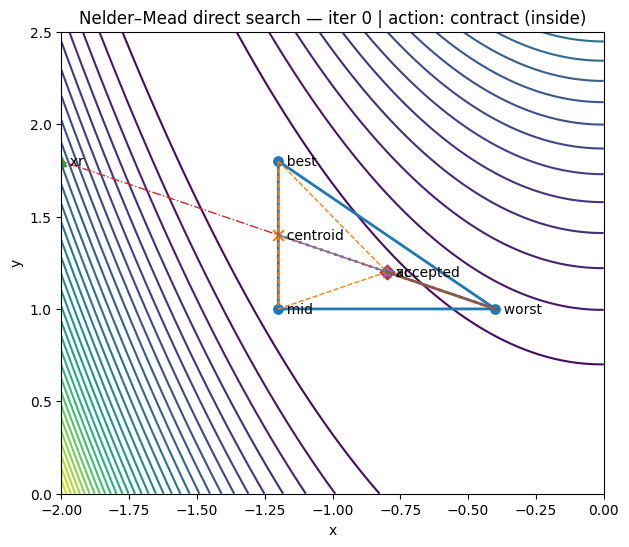

interactive(children=(IntSlider(value=0, description='k', max=8), Checkbox(value=True, description='toon pad (…

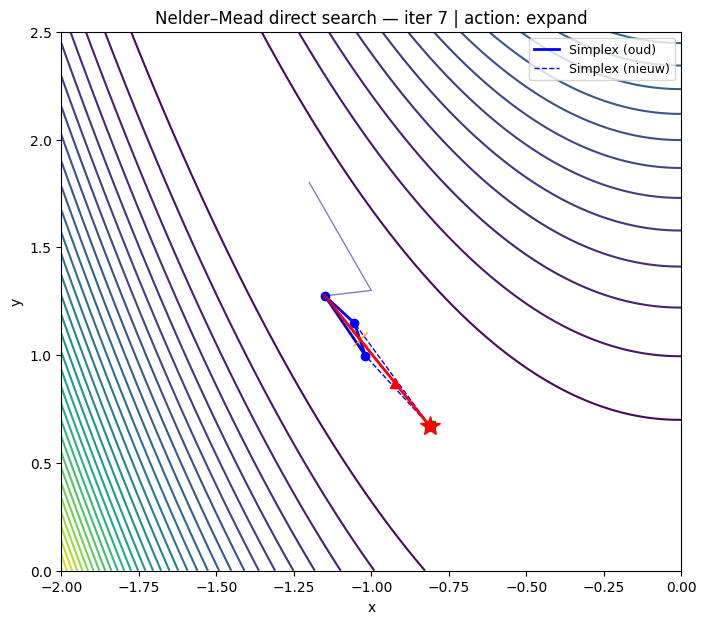

In [ ]:
if __name__ == "__main__":
    plt.close("all")
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.animation import FuncAnimation

    # ----------------------------
    # Objective (kies er 1)
    # ----------------------------
    def rosenbrock(p, a=1.0, b=100.0):
        x, y = p
        return (a - x)**2 + b*(y - x**2)**2

    def himmelblau(p):
        x, y = p
        return (x**2 + y - 11)**2 + (x + y**2 - 7)**2


    # ----------------------------
    # Nelder–Mead met "trace info"
    # ----------------------------
    def nelder_mead_trace_2d(
        f, x0, step=1.0, max_iter=80,
        alpha=1.0, gamma=2.0, rho=0.5, sigma=0.5
    ):
        """
        Returns:
        trace: list[dict] met per iteratie:
            - simplex (gesorteerd: best, mid, worst)
            - centroid
            - trial points (xr, xe, xc)
            - action (reflect/expand/contract/shrink)
            - simplex_next
        """
        x0 = np.asarray(x0, dtype=float)
        simplex = np.array([
            x0,
            x0 + np.array([step, 0.0]),
            x0 + np.array([0.0, step]),
        ], dtype=float)

        trace = []

        for it in range(max_iter):
            vals = np.array([f(p) for p in simplex])
            order = np.argsort(vals)
            simplex = simplex[order]
            vals = vals[order]

            best, mid, worst = simplex
            f_best, f_mid, f_worst = vals

            centroid = 0.5 * (best + mid)

            # Reflectie
            xr = centroid + alpha * (centroid - worst)
            f_xr = f(xr)

            info = dict(
                it=it,
                simplex=simplex.copy(),
                vals=vals.copy(),
                best=best.copy(),
                mid=mid.copy(),
                worst=worst.copy(),
                centroid=centroid.copy(),
                xr=xr.copy(),
                xe=None,
                xc=None,
                action=None,
                accepted=None,
                simplex_next=None,
            )

            simplex_next = simplex.copy()

            if f_best <= f_xr < f_mid:
                # accept reflect
                simplex_next[2] = xr
                info["action"] = "reflect"
                info["accepted"] = xr.copy()

            elif f_xr < f_best:
                # expansie
                xe = centroid + gamma * (xr - centroid)
                f_xe = f(xe)
                info["xe"] = xe.copy()
                if f_xe < f_xr:
                    simplex_next[2] = xe
                    info["action"] = "expand"
                    info["accepted"] = xe.copy()
                else:
                    simplex_next[2] = xr
                    info["action"] = "reflect (better than expand)"
                    info["accepted"] = xr.copy()

            else:
                # contractie / shrink
                if f_mid <= f_xr < f_worst:
                    # outside contraction (tussen centroid en xr)
                    xc = centroid + rho * (xr - centroid)
                    info["xc"] = xc.copy()
                    if f(xc) <= f_xr:
                        simplex_next[2] = xc
                        info["action"] = "contract (outside)"
                        info["accepted"] = xc.copy()
                    else:
                        # shrink
                        simplex_next[1] = best + sigma * (simplex_next[1] - best)
                        simplex_next[2] = best + sigma * (simplex_next[2] - best)
                        info["action"] = "shrink"

                else:
                    # inside contraction (tussen centroid en worst)
                    xc = centroid - rho * (centroid - worst)
                    info["xc"] = xc.copy()
                    if f(xc) < f_worst:
                        simplex_next[2] = xc
                        info["action"] = "contract (inside)"
                        info["accepted"] = xc.copy()
                    else:
                        # shrink
                        simplex_next[1] = best + sigma * (simplex_next[1] - best)
                        simplex_next[2] = best + sigma * (simplex_next[2] - best)
                        info["action"] = "shrink"

            info["simplex_next"] = simplex_next.copy()
            trace.append(info)
            simplex = simplex_next

        return trace


    # ----------------------------
    # Plot helpers
    # ----------------------------
    def _close_triangle(S):
        return np.vstack([S, S[0]])

    def plot_direct_search_iteration(
        f, trace, k,
        xlim=(-2, 2), ylim=(-1, 3),
        contour_levels=35,
        show_contours=True,
        show_path=True,
    ):
        """
        Visualiseert iteratie k:
        - simplex (best, mid, worst)
        - centroid
        - rechte lijn centroid--worst
        - trial point(s) (xr, xe, xc) + segmenten op die lijn
        - transitie: oud worst -> geaccepteerde nieuwe punt (als niet-shrink)
        """
        k = int(np.clip(k, 0, len(trace)-1))
        info = trace[k]

        # grid voor contours
        if show_contours:
            xs = np.linspace(xlim[0], xlim[1], 350)
            ys = np.linspace(ylim[0], ylim[1], 350)
            X, Y = np.meshgrid(xs, ys)
            Z = np.vectorize(lambda x, y: f((x, y)))(X, Y)
            # log-schaal helpt vaak; automatisch als de dynamische range groot is
            use_log = (np.nanmax(Z) / max(np.nanmin(Z), 1e-12)) > 1e6
            Zp = np.log10(Z + 1e-12) if use_log else Z

        fig, ax = plt.subplots(figsize=(7, 6))
        ax.set_xlim(*xlim)
        ax.set_ylim(*ylim)
        ax.set_xlabel("x")
        ax.set_ylabel("y")

        if show_contours:
            ax.contour(X, Y, Zp, levels=contour_levels)

        S = info["simplex"]  # best, mid, worst
        best, mid, worst = info["best"], info["mid"], info["worst"]
        centroid = info["centroid"]
        xr = info["xr"]
        xe = info["xe"]
        xc = info["xc"]
        action = info["action"]
        accepted = info["accepted"]
        Snext = info["simplex_next"]

        # simplex (oud)
        tri = _close_triangle(S)
        ax.plot(tri[:, 0], tri[:, 1], lw=2)

        # simplex (nieuw) licht (zodat je de stap ziet)
        tri2 = _close_triangle(Snext)
        ax.plot(tri2[:, 0], tri2[:, 1], lw=1, linestyle="--")

        # punten + labels
        ax.scatter(S[:, 0], S[:, 1], s=45)
        ax.text(best[0], best[1], "  best", va="center")
        ax.text(mid[0], mid[1], "  mid", va="center")
        ax.text(worst[0], worst[1], "  worst", va="center")

        # centroid
        ax.scatter([centroid[0]], [centroid[1]], s=60, marker="x")
        ax.text(centroid[0], centroid[1], "  centroid", va="center")

        # DE "STRAIGHT LINE": centroid -> worst (zoals in de theorie)
        ax.plot([centroid[0], worst[0]], [centroid[1], worst[1]], linestyle=":", lw=2)

        # reflectie-lijn: worst -> centroid -> xr (zelfde rechte)
        ax.plot([worst[0], centroid[0], xr[0]], [worst[1], centroid[1], xr[1]], linestyle="-.", lw=1)
        ax.scatter([xr[0]], [xr[1]], s=55, marker="^")
        ax.text(xr[0], xr[1], "  xr", va="center")

        # eventueel expansiepunt
        if xe is not None:
            ax.plot([centroid[0], xr[0], xe[0]], [centroid[1], xr[1], xe[1]], lw=1)
            ax.scatter([xe[0]], [xe[1]], s=55, marker="s")
            ax.text(xe[0], xe[1], "  xe", va="center")

        # eventueel contractiepunt
        if xc is not None:
            ax.plot([centroid[0], xc[0]], [centroid[1], xc[1]], lw=1)
            ax.scatter([xc[0]], [xc[1]], s=55, marker="D")
            ax.text(xc[0], xc[1], "  xc", va="center")

        # transitie van worst naar accepted (als er eentje is)
        if accepted is not None:
            ax.plot([worst[0], accepted[0]], [worst[1], accepted[1]], lw=2)
            ax.scatter([accepted[0]], [accepted[1]], s=80, marker="*")
            ax.text(accepted[0], accepted[1], "  accepted", va="center")

        # pad van beste punten (optioneel)
        if show_path:
            bests = np.array([t["best"] for t in trace[:k+1]])
            ax.plot(bests[:, 0], bests[:, 1], lw=1)

        ax.set_title(f"Nelder–Mead direct search — iter {k} | action: {action}")
        plt.show()


    # ----------------------------
    # Run & interactief kiezen
    # ----------------------------
    f = rosenbrock     # of: himmelblau
    x0 = (-1.2, 1.0)

    MAX_ITER = 120     # <-- hier kies je hoeveel iteraties je wil berekenen
    trace = nelder_mead_trace_2d(f, x0, step=0.8, max_iter=MAX_ITER)

    # Kies plotvenster passend bij je functie
    XLIM = (-2.0, 0)
    YLIM = (0, 2.5)

    # 1) Handmatig: plot een specifieke iteratie
    plot_direct_search_iteration(f, trace, k=0, xlim=XLIM, ylim=YLIM)

    # 2) Slider (Jupyter): kies iteratie met een schuif
    try:
        from ipywidgets import interact, IntSlider, Checkbox
        interact(
            lambda k, show_path: plot_direct_search_iteration(
                f, trace, k,
                xlim=XLIM, ylim=YLIM,
                show_path=show_path
            ),
            k=IntSlider(min=0, max=8, step=1, value=0),
            show_path=Checkbox(value=True, description="toon pad (best)")
        )
    except Exception as e:
        print("ipywidgets niet beschikbaar (of niet in deze omgeving). Gebruik plot_direct_search_iteration(..., k=...).")

    from matplotlib.animation import FuncAnimation

    def animate_direct_search(f, trace, xlim=(-2, 2), ylim=(-1, 3), 
                         contour_levels=35, show_contours=True):
        """Animatie van Nelder-Mead direct search (eerste 8 iteraties) - volledig."""
        
        # Limiteer tot eerste 8 iteraties
        trace_limited = trace[:8]
        
        # Grid voor contours
        if show_contours:
            xs = np.linspace(xlim[0], xlim[1], 350)
            ys = np.linspace(ylim[0], ylim[1], 350)
            X, Y = np.meshgrid(xs, ys)
            Z = np.vectorize(lambda x, y: f((x, y)))(X, Y)
            use_log = (np.nanmax(Z) / max(np.nanmin(Z), 1e-12)) > 1e6
            Zp = np.log10(Z + 1e-12) if use_log else Z
        
        fig, ax = plt.subplots(figsize=(8, 7))
        ax.set_xlim(*xlim)
        ax.set_ylim(*ylim)
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        
        if show_contours:
            ax.contour(X, Y, Zp, levels=contour_levels)
        
        # Plot elementen (initialiseer leeg)
        line_old, = ax.plot([], [], lw=2, label="Simplex (oud)", color="blue")
        line_new, = ax.plot([], [], lw=1, linestyle="--", label="Simplex (nieuw)", color="blue")
        scatter_pts, = ax.plot([], [], 'o', markersize=6, color="blue")
        scatter_centroid, = ax.plot([], [], 'x', markersize=10, color="orange")
        scatter_xr, = ax.plot([], [], '^', markersize=7, color="red")
        scatter_xe, = ax.plot([], [], 's', markersize=7, color="green")
        scatter_xc, = ax.plot([], [], 'D', markersize=7, color="purple")
        scatter_accepted, = ax.plot([], [], '*', markersize=15, color="red")
        
        # Lijnen
        line_centroid_worst, = ax.plot([], [], ':', lw=2, color="orange")
        line_reflection, = ax.plot([], [], '-.', lw=1, color="red")
        line_expansion, = ax.plot([], [], lw=1, color="green")
        line_contraction, = ax.plot([], [], lw=1, color="purple")
        line_transition, = ax.plot([], [], lw=2, color="red")
        
        # Padvolk van beste punten
        line_path, = ax.plot([], [], lw=1, color="darkblue", alpha=0.5)
        
        title = ax.set_title("")
        ax.legend(loc="upper right", fontsize=9)
        
        def _close_triangle(S):
            return np.vstack([S, S[0]])
        
        def update(k):
            info = trace_limited[k]
            S = info["simplex"]
            Snext = info["simplex_next"]
            action = info["action"]
            best = info["best"]
            mid = info["mid"]
            worst = info["worst"]
            centroid = info["centroid"]
            xr = info["xr"]
            xe = info["xe"]
            xc = info["xc"]
            accepted = info["accepted"]
            
            # Oude simplex
            tri = _close_triangle(S)
            line_old.set_data(tri[:, 0], tri[:, 1])
            
            # Nieuwe simplex
            tri2 = _close_triangle(Snext)
            line_new.set_data(tri2[:, 0], tri2[:, 1])
            
            # Punten
            scatter_pts.set_data(S[:, 0], S[:, 1])
            
            # Centroid
            scatter_centroid.set_data([centroid[0]], [centroid[1]])
            
            # Centroid-worst lijn
            line_centroid_worst.set_data([centroid[0], worst[0]], 
                                        [centroid[1], worst[1]])
            
            # Reflectie lijn (worst -> centroid -> xr)
            line_reflection.set_data([worst[0], centroid[0], xr[0]], 
                                    [worst[1], centroid[1], xr[1]])
            scatter_xr.set_data([xr[0]], [xr[1]])
            
            # Expansie (als aanwezig)
            if xe is not None:
                line_expansion.set_data([centroid[0], xr[0], xe[0]], 
                                    [centroid[1], xr[1], xe[1]])
                scatter_xe.set_data([xe[0]], [xe[1]])
            else:
                scatter_xe.set_data([], [])
                line_expansion.set_data([], [])
            
            # Contractie (als aanwezig)
            if xc is not None:
                line_contraction.set_data([centroid[0], xc[0]], 
                                        [centroid[1], xc[1]])
                scatter_xc.set_data([xc[0]], [xc[1]])
            else:
                scatter_xc.set_data([], [])
                line_contraction.set_data([], [])
            
            # Transitie worst -> accepted
            if accepted is not None:
                line_transition.set_data([worst[0], accepted[0]], 
                                        [worst[1], accepted[1]])
                scatter_accepted.set_data([accepted[0]], [accepted[1]])
            else:
                scatter_accepted.set_data([], [])
                line_transition.set_data([], [])
            
            # Pad van beste punten
            bests = np.array([t["best"] for t in trace_limited[:k+1]])
            line_path.set_data(bests[:, 0], bests[:, 1])
            
            title.set_text(f"Nelder–Mead direct search — iter {k} | action: {action}")
            
            return (line_old, line_new, scatter_pts, scatter_centroid, scatter_xr, 
                    scatter_xe, scatter_xc, scatter_accepted, line_centroid_worst,
                    line_reflection, line_expansion, line_contraction, line_transition, 
                    line_path, title)
        
        anim = FuncAnimation(fig, update, frames=len(trace_limited), 
                            interval=800, blit=True, repeat=True)
        return anim

    # Animatie maken en opslaan
    anim = animate_direct_search(f, trace, xlim=XLIM, ylim=YLIM)
    anim.save("nelder_mead_stappen.gif", writer="pillow", fps=0.2)
    plt.show()
    

### Steepest Descent

As expected, greater use of the objective function and its derivatives leads to faster methods. 
The negative gradient of a differentiable function $f:\mathbb{R}^n\rightarrow \mathbb{R}$ points *downhill* and locally, $-\nabla f(\mathbf{x})$ is the direction of *steepest descent*. 
Thus, the negative gradient is a potentially fruitful direction in which to seek points having lower function values. 

The maximum possible benefit from movement in any downhill direction is to attain the minimum of the objective function along that direction. 
For any fixed $\mathbf{x}$ and direction $\mathbf{s} = -\nabla f(\mathbf{x})$, we can define a function $\phi:\mathbb{R}\rightarrow \mathbb{R}$: 

$$
\phi(\alpha) = f(\mathbf{x}+\alpha\mathbf{s})
$$

In this way the problem of minimizing the objective function $f$ along the direction of $\mathbf{s}$ from $\mathbf{x}$ is seen to be a one-dimensional optimization problem that can be solved by one of the methods discussed in the previous section. 
Once a minimum is found in a certain direction, the negative gradient is computed at this new point and the process is repeated until convergence. 
This process of minimizing an objective function only along a fixed line in $\mathbb{R}^n$ is called a *line search*.

The steepest descent method is very reliable in that it can always make progress provided the gradient is nonzero. However, as the example below will illustrate the resulting iterations can zigzag back and forth, making very slow progress. 
In general, the convergence rate of steepest descent is only linear. 

An implementation of the steepest descent method is shown below, together with an example in two dimensions. 

  i        f(x)
---  ----------
  0  3.8125e+01
  1  1.7184e+01
  2  7.8978e+00
  3  3.7803e+00
  4  1.9545e+00
  5  1.1450e+00
  6  7.8599e-01
  7  6.2681e-01
  8  5.5623e-01
  9  5.2493e-01


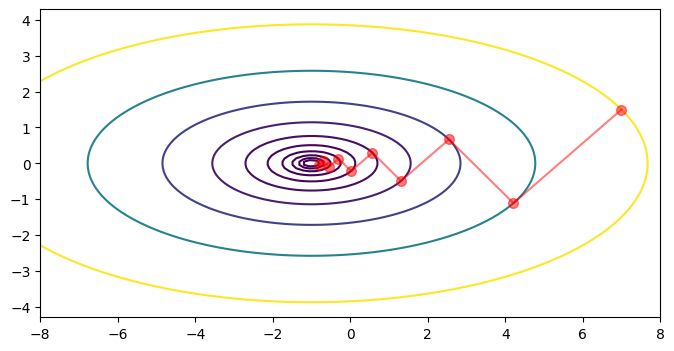

In [11]:
def my_steepest_descent(f, fp, x):
    """Illustrative implementation of the steepest descent method."""
    print("  i        f(x)")
    print("---  ----------")
    print(f"{0:3d}  {f(x):8.4e}")

    xk = []
    xk.append([x])

    for i in range(1, 10):
        s = -fp(x)

        # line search
        res = optimize.minimize_scalar(
            (lambda alpha, x, s: f(x + alpha * s)), [0, 1], args=(x, s), tol=1e-8
        )

        # step to minimum along line
        x = x + res.x * s
        xk.append([x])
        print(f"{i:3d}  {f(x):8.4e}")

    return np.array(xk)


results_sd = my_steepest_descent(func_multi, func_multi_p, x=np.array([7, 1.5]))
plot_opt_trajectory(results_sd, "steepest")

### Newton's Method

A broader view of the objective function can, once again, be gained from a local quadratic approximation, which can be obtained from a truncated Taylor series expansion

$$
    f(\mathbf{x} + \mathbf{s}) \approx f(\mathbf{x}) + \nabla f(\mathbf{x})^\intercal\mathbf{s} + \frac{1}{2}\mathbf{s}^\intercal \mathbf{H}_{f}(\mathbf{x})\mathbf{s}, 
$$


where $\mathbf{H}_f(\mathbf{x})$ is the *Hessian matrix*. 
This quadratic function in $\mathbf{s}$ is minimized when 

$$
    \mathbf{H}_f(\mathbf{x})\mathbf{s} = -\nabla f(\mathbf{x}).
$$

The convergence rate of Newton's method for unconstrained optimization is normally quadratic but the method is unreliable unless started close enough to the solution. 
While Newton's method does not require a line search, it may still be advisable to perform a line search along the direction of the Newton step in order to make the method more robust.

Below, Newton's method is applied to the same two-dimensional example as before. 

  i        f(x)
---  ----------
  0  3.8125e+01
  1  5.0000e-01
  2  5.0000e-01
  3  5.0000e-01
  4  5.0000e-01
  5  5.0000e-01
  6  5.0000e-01
  7  5.0000e-01
  8  5.0000e-01
  9  5.0000e-01


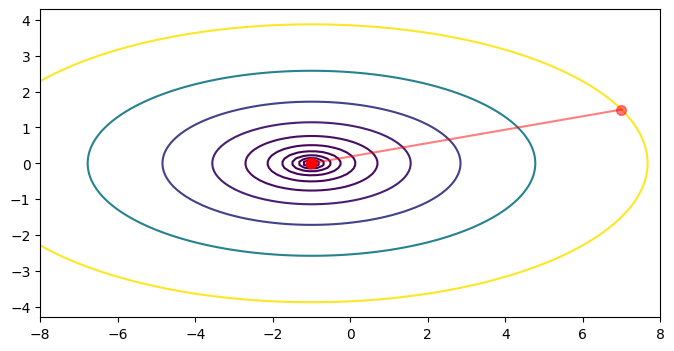

In [12]:
def my_newton_method_nd(f, fp, fpp, x):
    """Illustrative implementation of the multi-dimensional Newton method."""
    print("  i        f(x)")
    print("---  ----------")
    print(f"{0:3d}  {f(x):8.4e}")

    xk = []
    xk.append([x])

    for i in range(1, 10):
        # solve linear system
        hessian = fpp(x)
        s = linalg.solve(hessian, -fp(x))

        # make step
        x = x + s
        xk.append([x])
        print(f"{i:3d}  {f(x):8.4e}")

    return np.array(xk)


results_nm = my_newton_method_nd(
    func_multi, func_multi_p, func_multi_pp, x=np.array([7, 1.5])
)
plot_opt_trajectory(results_nm, "newton_nd")

### Quasi-Newton Methods

Newton's method usually converges very rapidly once it nears a solution, but it requires a substantial amount of work per iteration. 
Specifically, for a problem with a dense Hessian matrix, each iteration requires $\mathcal{O}(n^2)$ scalar function evaluations to form the gradient and the Hessian matrix while $\mathcal{O}(n^3)$ arithmetic operations are required to solve the linear system for the Newton step. 
Many variants of Newton's method have been developed to reduce its overhead or improve its reliability, or both. These *quasi-Newton methods* have the general form

$$
    \mathbf{x}_{k+1} = \mathbf{x}_{k} - \alpha_k\mathbf{B}^{-1}_k\nabla f(\mathbf{x}_{k})
$$

where $\alpha_k$ is a line search parameter and $\mathbf{B}_k$ is some approximation of the Hessian matrix obtained in any number of ways, including secant updating, finite differences, periodic reevaluation, or neglecting some terms in the true Hessian of the objective function. 

Many quasi-Newton methods are more robust than the pure Newton method and have considerably lower overhead per iteration yet remain superlinear (though not quadratic). 

### Secant Updating Methods

Several secant updating formulas for unconstrained minimization have been developed that not only preserve symmetry in the approximate Hessian matrix but also preserve positive definiteness. 
Symmetry reduces the amount of work and storage required by about half, and positive definiteness guarantees that the resulting quasi-Newton step will be a descent direction. 
In practice, a factorization of $\mathbf{B}_k$ is updated rather than $\mathbf{B}_k$ itself, so that the linear system for the quasi-Newton step can be solved at a cost per iteration of $\mathcal{O}(n^2)$ rather than $\mathcal{O}(n^3)$ operations. 

Unlike Newton's method for optimization, no second derivatives are required. 
And most of these methods are often started with $\mathbf{B}_0 = \mathbf{I}$, which means the first step is along the negative gradient (i.e. along the direction of steepest descent) and then second derivative information is gradually built up in the approximate Hessian matrix by updating over successive iterations. 

One of the most effective secant updating methods for optimization is called BFGS of which an implementation is shown below. 

  i        f(x)
---  ----------
  0  3.8125e+01
  1  9.0500e+01
  2  9.6728e+00
  3  1.5446e+00
  4  5.0314e-01
  5  5.0001e-01
  6  5.0000e-01
  7  5.0000e-01


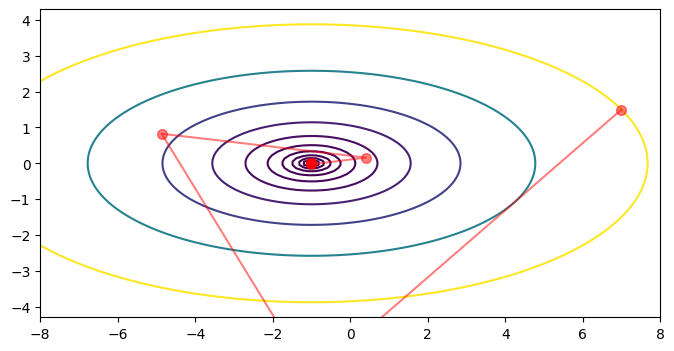

In [16]:
def my_bfgs(f, fp, B, x):
    """Illustrative implementation of the BFGS Quasi Newton method."""

    print("  i        f(x)")
    print("---  ----------")
    print(f"{0:3d}  {f(x):8.4e}")

    xk = []
    xk.append([x])
    tol = 1e-8
    y = 1
    s = 1
    i = 0

    while (np.dot(y, s)) >= tol:
        i += 1
        # solve linear system + make step (cfr. Newton's Method)
        s = linalg.solve(B, -fp(x))
        x_new = x + s

        # update approximation of Hessian
        y = fp(x_new) - fp(x)
        B = (
            B
            + (np.outer(y, y) / np.dot(y, s))
            - (np.dot(np.outer(np.dot(B, s), s), B) / multi_dot([s, B, s]))
        )  # update B with BFGS formula

        x = x_new
        xk.append([x])
        print(f"{i:3d}  {f(x):8.4e}")

    return np.array(xk)


# initial guess B = I
results_bfgs = my_bfgs(
    func_multi, func_multi_p, B=np.array([[1, 0], [0, 1]]), x=np.array([7, 1.5])
)
plot_opt_trajectory(results_bfgs, "bfgs")

Note that the increase in function value on the first iteration in the example above could have been avoided by using a line search. 
Such a line search can also be used to enhance the effectiveness of the method. 
For a quadratic expression it can be stated that if an exact line search is added to every iteration of the BFGS method, it will terminate at the exact solution after at most $n$ iterations, where $n$ is the dimension of the problem. 

### Conjugate Gradient Method

The conjugate gradient method is another alternative to Newton's method that does not require explicit second derivatives. 
Indeed, unlike secant updating methods, the conjugate gradient method does not even store an approximation to the Hessian matrix, which makes it especially **suitable for very large problems**. 

As the name suggests, the conjugate gradient method also uses gradients, but in contrast to the steepest descent method it avoids repeatedly searching in the same directions by modifying the new gradient at each step to remove components in previous directions. 
The resulting sequence of *conjugate* (i.e. orthogonal in the inner product $(\mathbf{x},\mathbf{y}) = \mathbf{x}^\intercal\mathbf{H}_f\mathbf{y}$ search directions implicitly accumulates information about the Hessian matrix as iterations proceed. 

Theoretically, the conjugate gradient method is exact after at most $n$ iterations for a quadratic objective function in $n$ dimensions, but it is usually quite effective for more general unconstrained optimization problems as well. 
It is common to restart the algorithm after every $n$ iterations by restarting to use the negative gradient at the current point. 

In the following example, an implementation of the conjugate gradient method is applied to minimize a function in two dimensions. 

  i        f(x)
---  ----------
  0  3.8125e+01
  1  1.7184e+01
  2  5.0000e-01
  3  5.0000e-01
  4  5.0000e-01


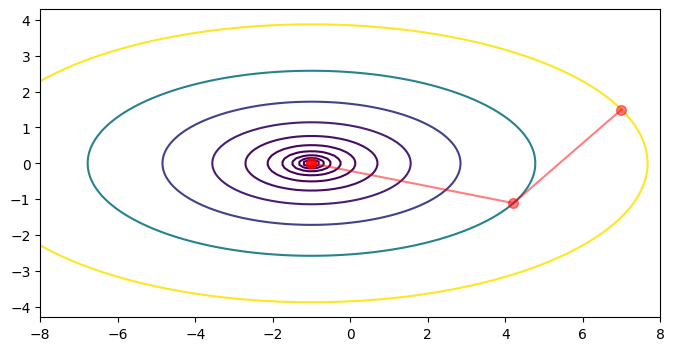

In [17]:
def my_conjugate_gradient(f, fp, x):
    """Illustrative implementation of the conjugate gradient method."""
    print("  i        f(x)")
    print("---  ----------")
    print(f"{0:3d}  {f(x):8.4e}")

    xk = []
    xk.append([x])

    # initialize parameters
    g = fp(x)
    s = -g
    for i in range(1, 5):
        # line search + make step
        res = optimize.minimize_scalar(
            (lambda alpha, x, s: f(x + alpha * s)), [0, 1], args=(x, s), tol=1e-8
        )
        x_new = x + res.x * s

        g_new = fp(x_new)
        # Polak-Ribiere with built-in reset
        b = max(np.inner(g_new - g, g_new) / np.inner(g, g), 0)
        s = -g_new + b * s

        x = x_new
        g = g_new

        xk.append([x])
        print(f"{i:3d}  {f(x):8.4e}")

    return np.array(xk)


results_cg = my_conjugate_gradient(func_multi, func_multi_p, x=np.array([7, 1.5]))
plot_opt_trajectory(results_cg, "cg")

## Non-linear Least Squares

Least squares data fitting can be viewed as an optimization problem. 
Given data points $(t_i,y_i), i = 1,\dots,m$, we wish to find the vector $\mathbf{x} \in \mathbb{R}^n$ of parameters that gives the best fit to the model function $f(t,\mathbf{x})$, where $f:\mathbb{R}^{n+1} \rightarrow \mathbb{R}$. 
Previously, we only considered cases in which the model function $f$ was linear in the components of $\mathbf{x}$ but now we are in a position to consider *nonlinear least squares* as a special case of nonlinear optimization. 

If we define the components of the *residual* function $\mathbf{r}:\mathbb{R}^n \rightarrow \mathbb{R}^m$ by 

$$
r_i(\mathbf{x}) = y_i - f(t_i,\mathbf{x}), \quad i = 1,\dots,m,
$$

then we wish to minimize the function

$$
\phi(\mathbf{x}) = \frac{1}{2}\mathbf{r}(\mathbf{x})^\intercal\mathbf{r}(\mathbf{x})
$$

i.e. the sum of squares of the residual components (the factor 1/2 is inserted for later convenience and has no effect on the optimal value for $\mathbf{x}$). 
If we apply Newton's method and $\mathbf{x}_k$ is an approximate solution, then the Newton step $\mathbf{s}_k$ is given by the linear system 

$$
\mathbf{H}_\phi(\mathbf{x}_k)\mathbf{s}_k = -\nabla\phi(\mathbf{x}_k)
$$


where the gradient vector and Hessian matrix of $\phi$ are given by

$$
\nabla\phi(\mathbf{x}) = \mathbf{J}^\intercal(\mathbf{x})\mathbf{r}(\mathbf{x})
$$
and 

$$
\mathbf{H}_\phi(\mathbf{x}) = \mathbf{J}^\intercal(\mathbf{x})\mathbf{J}(\mathbf{x}) + \sum_{i=1}^{m}r_i(\mathbf{x})\mathbf{H}_{r_i}(\mathbf{x})
$$

in which $\mathbf{J}^\intercal(\mathbf{x})$ is the Jacobian matrix of $\mathbf{r}(\mathbf{x})$, and $\mathbf{H}_{r_i}(\mathbf{x})$ denotes the Hessian matrix of the component function $r_i(\mathbf{x})$. 

The Newton step $\mathbf{s}_k$ is thus given by the linear system

$$
\left(\mathbf{J}^\intercal(\mathbf{x}_k)\mathbf{J}(\mathbf{x}_k) + \sum_{i=1}^{m}r_i(\mathbf{x}_k)\mathbf{H}_{r_i}(\mathbf{x}_k)\right)\mathbf{s}_k = -\mathbf{J}^\intercal(\mathbf{x}_k)\mathbf{r}(\mathbf{x}_k)
$$

The $m$ Hessian matrices $\mathbf{H}_{r_i}$ of the residual components are usually inconvenient and expensive to compute. Fortunately, we can exploit the special structure of this problem to avoid computing them in most cases, as we will see next. 

### Gauss-Newton Method

Note that in $\mathbf{H}_\phi$  each of the Hessian matrices $\mathbf{H}_{r_i}$ is multiplied by the corresponding residual component $r_i$, which should be small at a solution, provided that the model function fits the data reasonably well. This observation motivates the *Gauss-Newton method* for nonlinear least squares in which the terms involving $\mathbf{H}_{r_i}$ are dropped from the Hessian and the linear system 

$$
\left(\mathbf{J}^\intercal(\mathbf{x}_k)\mathbf{J}(\mathbf{x}_k)\right)\mathbf{s}_k = -\mathbf{J}^\intercal(\mathbf{x}_k)\mathbf{r}(\mathbf{x}_k)
$$

determines an approximate Newton step $\mathbf{s}_k$ at each iteration.

We recognize this system as the normal equations for the $m\times n$ linear least squares problem

$$
\mathbf{J}(\mathbf{x}_k)\mathbf{s}_k \cong -\mathbf{r}(\mathbf{x}_k)
$$

which can be solved more reliably by orthogonal factorization of $\mathbf{J}(\mathbf{x}_k)$. 
The next approximate solution is then given by $\mathbf{x}_{k+1} = \mathbf{x}_k+\mathbf{s}_k$ and the process is repeated until convergence. 
In effect, the Gauss-Newton method replaces a nonlinear least squares problem by a sequence of linear least squares problems whose solutions converge to the solution of the original nonlinear problem. 

If the residual components at the solution are relatively large, then the terms omitted from the Hessian matrix may not be negligible, in which case the Gauss-Newton approximation may be inaccurate and convergence is no longer guaranteed. 
In such cases, it may be best to use a general nonlinear optimization method that takes into account the full Hessian matrix. 

> **Example: radioactive decay**
>
> As an example the Gauss-Newton method will be used to fit the time dependency of the measured activity of a radioactive Fermium-246 sample. 
> The experiment yielded the following four data points
>
> | t (s) | A (s$^{-1}$) |
> |:-----:|:----------:|
> |  0.0  |     514    |
> |  1.0  |     303    |
> |  2.0  |     201    |
> |  3.0  |     113    |
>
> and the model prescription has the form
>
> $$
f(t,\mathbf{x}) =  x_1e^{x_2t} =  A_0e^{-\lambda t} ,
$$
>
> where $x_1 = A_0$ is the initial activity of the sample and $x_2 = -\lambda$ is the decay constant of the radioactive isotope which is closely related to the half-life constant.  
>
> For this model function, the entries of the Jacobian matrix of the residual function $\mathbf{r}$ are given by
>
> $$
\{\mathbf{J}(\mathbf{x})\}_{i,1} = \frac{\partial r_i(\mathbf{x})}{\partial x_1} = -e^{x_2t_i}, \qquad \{\mathbf{J}(\mathbf{x})\}_{i,2} = \frac{\partial r_i(\mathbf{x})}{\partial x_2} = -x_1t_ie^{x_2t_i}
$$
> 
> where the minus sign originates from the definition of $\mathbf{r}\  (=A_i-f(t_i,\mathbf{x}))$  and $i = 1,\dots,4$. If we start with $\mathbf{x}_0 = [480,\ \ -0.4]^\intercal$ as the initial guess, then the linear least squares problem to be solved for the Gauss-Newton step $\mathbf{s}_0$ is
>
> $$
\mathbf{J}(\mathbf{x}_0)\mathbf{s}_0 = 
\begin{bmatrix}
-1.00 & 0 \\
-0.67 & -322 \\
-0.45 & -431 \\
-0.30 & -434
\end{bmatrix} \mathbf{s}_0 \cong 
\begin{bmatrix}
-34.00 \\
\hphantom{-}18.75 \\
\hphantom{-}14.68 \\
\hphantom{-}31.57
\end{bmatrix} = -\mathbf{r}(\mathbf{x}_0)     
$$
>
> The least squares solution of this system is $\mathbf{s}_0 = [30.75,\ \ -0.089]^\intercal$ and hence we take $\mathbf{x}_1 = \mathbf{x}_0 + \mathbf{s}_0 = [510.75,\ \ -0.489]^\intercal$ for the next step. 
> As illustrated in the implementation below, the system converges after several iterations. 
> From the decay constant $\lambda = -x_2$ the half-life of Fermium-246 can be calculated according to 
>
> $$
T_{1/2} = \frac{\ln(2)}{\lambda} = \frac{\ln(2)}{0.494} = 1.4 s
$$
>
> which is indeed very close to the actual half-life of 1.5 s. 

In [18]:
def radioactiveModel(t, x):
    """model function"""
    return x[0] * np.exp(x[1] * t)


def jacobian(t, x):
    """Jacobian matrix of r(x)"""
    J1 = -np.exp(x[1] * t)
    J2 = -x[0] * t * np.exp(x[1] * t)

    return np.array([J1, J2]).T


def residual(t, y, x):
    return np.array(y - radioactiveModel(t, x))

Iteration    Parameters (x1, x2)               Squared Sum of Residuals
-----------------------------------------------------------------------
   1          480.0000,    -0.4000                    2720.0075
   2          510.7533,    -0.4893                     216.5387
   3          511.5595,    -0.4939                     210.9184
   4          511.5689,    -0.4939                     210.9179
   5          511.5690,    -0.4939                     210.9179


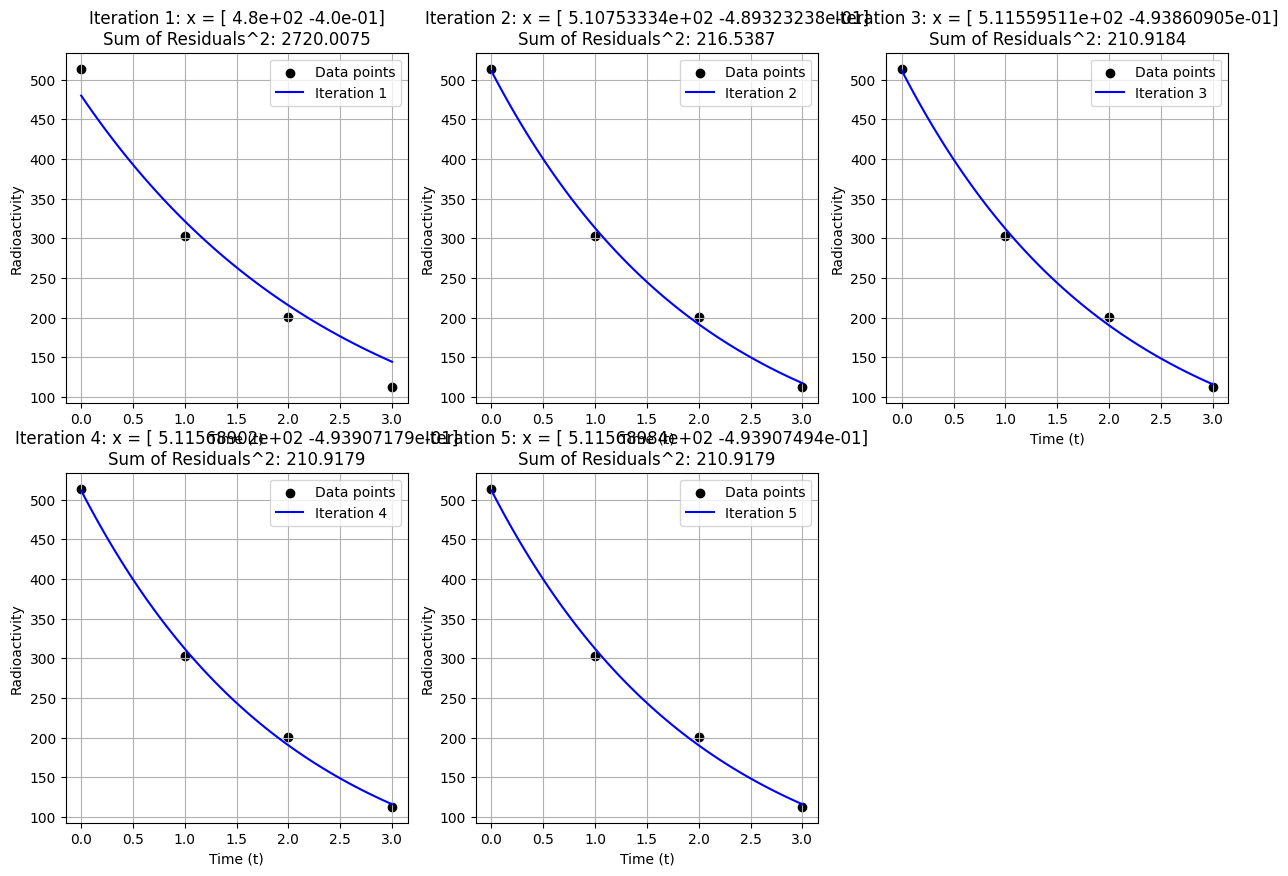

In [19]:
# Nonlinear least squares fitting using Gauss-Newton method
def gauss_newton_static_plot(initial_guess):
    t = np.arange(0, 4)
    y = np.array([514, 303, 201, 113])
    x = np.array(initial_guess)

    iterations = []
    models = []
    residuals = []

    print("Iteration    Parameters (x1, x2)               Squared Sum of Residuals")
    print("-----------------------------------------------------------------------")

    for i in range(5):  # Perform 5 iterations
        iterations.append(x.copy())
        models.append(radioactiveModel(t, x))
        r = residual(t, y, x)
        residuals.append(np.sum(r**2))  # Calculate squared sum of residuals

        print(
            f"{i + 1:>4}        {x[0]:>10.4f}, {x[1]:>10.4f}         "
            f"{residuals[-1]:>20.4f}"
        )

        J = jacobian(t, x)
        p, _, _, _ = lstsq(J, -r, rcond=None)
        x = x + p

    # Generate the static plot
    plt.close("gauss_newton")
    fig, axs = plt.subplots(2, 3, figsize=(15, 10), num="gauss_newton")
    axs = axs.flatten()

    t_fine = np.linspace(0, 3, 100)
    for i, ax in enumerate(axs[:5]):
        ax.scatter(t, y, label="Data points", color="black")
        ax.plot(
            t_fine,
            radioactiveModel(t_fine, iterations[i]),
            label=f"Iteration {i + 1}",
            color="blue",
        )
        ax.set_title(
            f"Iteration {i + 1}: x = {iterations[i]}\n"
            f"Sum of Residuals^2: {residuals[i]:.4f}"
        )
        ax.set_xlabel("Time (t)")
        ax.set_ylabel("Radioactivity")
        ax.legend()
        ax.grid()

    # Hide the last unused subplot
    axs[-1].axis("off")


# Call the function to generate the static plot
gauss_newton_static_plot([480, -0.4])

Like all methods based on Newton's method, the Gauss-Newton method for solving nonlinear least squares problems may fail to converge unless it is started sufficiently close to the solution. 
A line search can be used to improve its robustness, but additional modifications may be necessary to ensure that the computed step $\mathbf{s}_k$ is a descent direction when far from the solution. 

### Levenberg-Marquardt Method

The *Levenberg-Marquardt method* is a useful alternative when the Gauss-Newton method yields an ill-conditioned or rank-deficient linear least squares subproblem. 
At each iteration of this method, the linear system for the step $\mathbf{s}_k$ is of the form

$$
\left(\mathbf{J}^\intercal(\mathbf{x}_k)\mathbf{J}(\mathbf{x}_k) + \mu_k\mathbf{I}\right)\mathbf{s}_k = -\mathbf{J}^\intercal(\mathbf{x}_k)\mathbf{r}(\mathbf{x}_k)
$$

where $\mu_k$ is a nonnegative scalar parameter chosen by some strategy. The corresponding linear least squares problem to be solved is 

$$
\begin{bmatrix}
    \mathbf{J}(\mathbf{x}_k)\\
    \sqrt{\mu_k}\ \mathbf{I}
\end{bmatrix}  \mathbf{s}_k \cong 
\begin{bmatrix}
    -\mathbf{r}(\mathbf{x}_k)\\
    \mathbf{0}
\end{bmatrix}  
$$

This method can be interpreted as replacing the terms omitted from
the true Hessian by a scalar multiple of the identity matrix or as using a
weighted combination of the Gauss-Newton step and the steepest descent direction. 
With a suitable strategy for choosing the parameter $\mu_k$, typically based on a trust-region approach, the Levenberg-Marquardt method can be very robust in practice, and it forms the basis for several effective software packages for solving nonlinear least squares problems.

## Constrained optimization

So far, we only considered minima that occur at an interior point of the feasible set $S$. 
For **constrained optimization problems**, the minimum is often located outside the feasible set, meaning that the solution of the constrained optimization problem occurs on the boundary of the feasible set. 
The principles to find a minimum remains the same: a minimum occurs at $\mathbf{x}^*\in S$ when there is no downhill direction starting from $\mathbf{x}^*$, considering only **feasible directions**, i.e. directions for which the constraints continue to be satisfied. 

In general, the constraints can be linear or nonlinear and can be subdivided into the following two categories: 

* **Equality constraints** which are of the general form $\mathbf{g}(\mathbf{x}) = \mathbf{0}$
* **Inequality constraints** which are of the general form $\mathbf{h}(\mathbf{x}) \leq \mathbf{0}$

Inequality constraints may be irrelevant to the solution and a given inequality constraint $h_i(\mathbf{x}) \leq 0$ is said to be *active* or *binding* at a feasible point $\mathbf{x} \in \mathbf{S}$ if $h_i(\mathbf{x}) = 0$. Naturally, equality constraints are always active. 

Both equality-constrained and inequality-constrained problems can be solved using *Lagrange multipliers* although the optimality conditions become more complicated when inequality constraints are involved. 

> **Example: the Rosenbrock function**
>
> As an example, let us consider minimization of the Rosenbrock function
>
> $$
\min_{x_0,x_1}\ \left(100\ (x_1-x_0^2)^2 + (1 - x_0)^2\right)
$$
>
> under the condition that the following constraints apply:
>
> $$\begin{aligned}
x_0 + 2x_1 &\leq 1 \\
x_0^2 + x_1 &\leq 1\\
x_0^2 - x_1 &\leq 1\\
2x_0 + x_1 &= 1\\
0 \leq x_0 &\leq 1\\
-0.5 \leq x_1 &\leq 2
\end{aligned}$$
> 
> This constrained optimization problem has a unique solution $\mathbf{x}^* = [0.4149\quad 0.1701]^\intercal$ for which only the fourth constraint is active.
> Note, however, that the Rosenbrock function has a global minimum at $\mathbf{x}' = [1\
1]^\intercal$ but that this point is not a feasible point $\left(\mathbf{x'} \notin \mathbf{S}\right)$ because it violates multiple constraints.

### The trust-region constrained algorithm

The minimize function of `scipy.optimize` provides several algorithms for constrained minimization. 
One of which is the trust-region constrained algorithm, which deals with constrained minimization problems of the form:

$$
\begin{aligned}
& \min_{\mathbf{x}} f(\mathbf{x}) \\
& \begin{aligned}
\text{subject to:} \quad&\mathbf{c}_l \leq \mathbf{c}(\mathbf{x}) \leq \mathbf{c}_u \\
 & \mathbf{x}_l \leq \mathbf{x} \leq \mathbf{x}_u
\end{aligned}
\end{aligned}
$$

When $c_{l,j} = c_{u,j}$ the method reads the $j$<sup>th</sup> constraint as an equality constraint and deals with it accordingly. 
Besides that, one-sided constraints can be specified by setting the upper ($u$) or lower ($l$) bound to `np.inf` with the appropriate sign. 
As an illustration, this method will be applied to the Rosenbrock example. 

> **Example: the trust-region constrained algorithm**
> The method requires the constraints to be defined as a sequence of Bounds, LinearConstraint and NonlinearConstraint objects. 
Therefore the first step is to classify the constraints from the above example accordingly. 
> - There are two *bound constraints*, namely $0 \leq x_0 \leq 1$ and 
$-0.5 \leq x_1 \leq 2$.
> - There are two *linear constraints*, namely $x_0 + 2x_1 \leq 1$ and $2x_0 + x_1 = 1$
> - There are two *nonlinear constraints*, namely $x_0^2 + x_1 \leq 1$ and $x_0^2 - x_1 \leq 1$.
>
> The linear constraints can be written in the standard format
>
> $$
\begin{bmatrix}
-\infty \\ 1
\end{bmatrix}\leq 
\begin{bmatrix}
1 & 2 \\
2 & 1
\end{bmatrix}
\begin{bmatrix}
x_0 \\ x_1
\end{bmatrix}\leq
\begin{bmatrix}
1 \\ 1
\end{bmatrix}
$$
>
> Whereas the nonlinear constraints can be written as
>
> $$
\begin{bmatrix}
-\infty  \\ -\infty
\end{bmatrix}\leq 
\begin{bmatrix}
x_0^2+x_1 \\ x_0^2-x_1
\end{bmatrix}
= \mathbf{c}(\mathbf{x})
\leq
\begin{bmatrix}
1 \\ 1
\end{bmatrix}
$$
>
> The NonlinearConstraints object also takes the Jacobian matrix and a linear combination of Hessians of $\mathbf{c}(\mathbf{x})$ as optional arguments. 
If no Jacobian matrix or Hessian is passed, the gradient will be estimated using 2-point finite difference estimation with an absolute step size while the Hessian will be estimated using one of the quasi-Newton strategies. 
However, for this example they can be calculated with relative ease which gives: 
>
> $$
\mathbf{J}(\mathbf{x}) = 
\begin{bmatrix}
2x_0 & 1 \\
2x_0 & -1
\end{bmatrix}
$$
>
> $$
\mathbf{H}(\mathbf{x},\mathbf{v}) = \sum_{i} v_i\nabla^2c_i(\mathbf{x}) = 
v_0\begin{bmatrix}
2 & 0 \\
0 & 0
\end{bmatrix} + 
v_1\begin{bmatrix}
2 & 0 \\
0 & 0
\end{bmatrix}
$$
>
> With this information it is now possible to solve the constrained optimization problem with `scipy.optimize.minimize` as shown below. 

In [20]:
def rosen(x):
    return sum(100.0 * (x[1:] - x[:-1] ** 2.0) ** 2.0 + (1 - x[:-1]) ** 2.0)


def cons_c(x):
    return [x[0] ** 2 + x[1], x[0] ** 2 - x[1]]


def cons_J(x):
    return [[2 * x[0], 1], [2 * x[0], -1]]


def cons_H(x, v):
    return v[0] * np.array([[2, 0], [0, 0]]) + v[1] * np.array([[2, 0], [0, 0]])


# Initialize constraint objects
bounds = optimize.Bounds([0, -0.5], [1.0, 2.0])
linear_constraint = optimize.LinearConstraint([[1, 2], [2, 1]], [-np.inf, 1], [1, 1])
nonlinear_constraint = optimize.NonlinearConstraint(
    cons_c, -np.inf, 1, jac=cons_J, hess=cons_H
)

# Solve the optimization
x0 = np.array([0.5, 0])  # initial guess
res = optimize.minimize(
    rosen,
    x0,
    method="trust-constr",
    constraints=[linear_constraint, nonlinear_constraint],
    bounds=bounds,
)

print("Result: ", res.x)

Result:  [0.41494531 0.17010937]


which indeed corresponds to the expected solution of $\mathbf{x}^* = [0.4149\quad 0.1701]^\intercal$

In [21]:
def plot_rosen(less_busy=False):
    """Plot Rosenbrock function with constraints and (constrained) minimum."""

    # Define the Rosenbrock function and its constraints
    def Rosen(x, y):
        return (1 - x) ** 2 + 100.0 * (y - x**2) ** 2

    def constraint_1(x, y):
        return x - 2 * y - 1  # Reformulated as a <= 0

    def constraint_2(x, y):
        return x**2 + y - 1  # Reformulated as a <= 0

    def constraint_3(x, y):
        return x**2 - y - 1  # Reformulated as a <= 0

    def constraint_4(x, y):
        return 2 * x + y - 1  # Reformulated as a <= 0

    def constraint_5a(x, y):
        return x - 1  # Reformulated as a <= 0

    def constraint_5b(x, y):
        return -x  # Reformulated as a <= 0

    def constraint_6a(x, y):
        return y - 1  # Reformulated as a <= 0

    def constraint_6b(x, y):
        return -y - 0.5  # Reformulated as a <= 0

    # Define grid
    x = np.linspace(-2.0, 2.0, 300)
    y = np.linspace(-1.0, 3.0, 300)
    xx, yy = np.meshgrid(x, y)

    # Plot Rosenbrock function
    plt.close("rosen")
    fig, ax = plt.subplots(num="rosen")
    cm = ax.contourf(
        xx, yy, Rosen(xx, yy), 20, cmap="viridis", alpha=0.7 if less_busy else 1
    )
    plt.colorbar(cm)

    # Add contour lines
    ax.contour(xx, yy, np.log(Rosen(xx, yy)), 20, colors="black", linewidths=1.0)

    # Plot constraints
    constraints = [
        constraint_1,
        constraint_2,
        constraint_3,
        constraint_4,
        constraint_5a,
        constraint_5b,
        constraint_6a,
        constraint_6b,
    ]

    if less_busy:
        # Less busy: shade regions outside feasible set
        for constraint in constraints:
            ax.contourf(
                xx,
                yy,
                constraint(xx, yy),
                levels=[0, np.inf],
                colors=["gray"],
                alpha=1,
            )
    else:
        # Full plot: add detailed constraint lines
        for constraint in constraints:
            ax.contour(
                xx,
                yy,
                constraint(xx, yy),
                levels=[0],
                colors="red",
                alpha=0.8,
                linewidths=1.0,
            )

    # Mark points
    x_min, y_min = res.x
    ax.plot(x_min, y_min, "mo", label="Constrained Minimum")
    ax.plot(1, 1, "yo", label="Unconstrained Minimum")

    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.legend(loc=0, fontsize="small")


# Objective function and constraints
def rosen(x):
    return sum(100.0 * (x[1:] - x[:-1] ** 2.0) ** 2.0 + (1 - x[:-1]) ** 2.0)


def cons_c(x):
    return [x[0] ** 2 + x[1], x[0] ** 2 - x[1]]


def cons_J(x):
    return [[2 * x[0], 1], [2 * x[0], -1]]


def cons_H(x, v):
    return v[0] * np.array([[2, 0], [0, 0]]) + v[1] * np.array([[2, 0], [0, 0]])


# Initialize constraint objects
bounds = optimize.Bounds([0, -0.5], [1.0, 2.0])
linear_constraint = optimize.LinearConstraint([[1, 2], [2, 1]], [-np.inf, 1], [1, 1])
nonlinear_constraint = optimize.NonlinearConstraint(
    cons_c, -np.inf, 1, jac=cons_J, hess=cons_H
)

# Solve the optimization
x0 = np.array([0.5, 0])  # initial guess
res = optimize.minimize(
    rosen,
    x0,
    method="trust-constr",
    constraints=[linear_constraint, nonlinear_constraint],
    bounds=bounds,
)

print("Result: ", res.x)

Result:  [0.41494531 0.17010937]


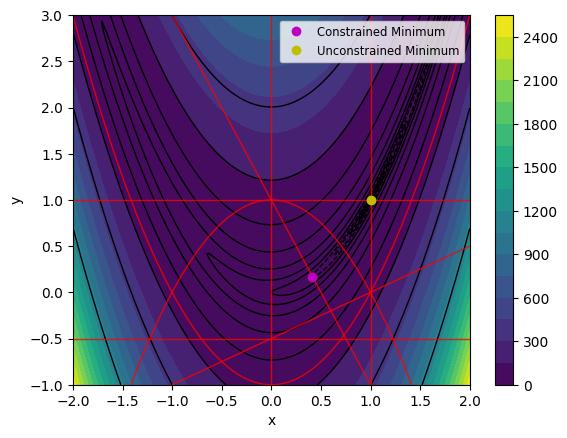

In [22]:
plot_rosen(less_busy=False);  # Full plot

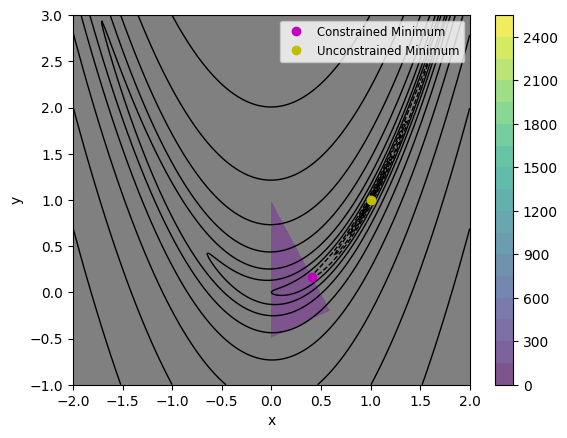

In [23]:
plot_rosen(less_busy=True)  # Less busy plot